In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Read txt file into a list called filenames
path = r'.'
filenames = glob.glob(path + "/*.txt")

filenames

['./RQ.20180501HW_macrophage coculture with islets cytokines.txt',
 './RQ20191013_ParC5_Amy_20191014_113558.txt']

In [3]:
# Import txt file into a data frame
filename= 'RQ20191013_ParC5_Amy_20191014_113558.txt'
df = pd.read_csv(filename,skiprows=10, sep="\t")
df.head()


,Well,Sample Name,Detector Name,Reporter,Task,Ct,Tm Value,Tm Type,Quantity,Qty Mean,...,EW,BPR,NAW,HNS,HRN,EAF,BAF,TAF,CAF,Unnamed: 33
0,77,ParC5,r-aqp5,SYBR,Unknown,33.01541,83.7,Auto Tm,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,78,ParC5,r-aqp5,SYBR,Unknown,32.42996,84.0,Auto Tm,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,79,ParC5_CHAPS,r-aqp5,SYBR,Unknown,32.67913,84.0,Auto Tm,NaN,NaN,...,NaN,NaN,NaN,true,NaN,NaN,NaN,NaN,NaN,NaN
3,80,ParC5_CHAPS,r-aqp5,SYBR,Unknown,32.380444,83.9,Auto Tm,NaN,NaN,...,NaN,NaN,NaN,true,NaN,NaN,NaN,NaN,NaN,NaN
4,81,ParC5_Matrigel,r-aqp5,SYBR,Unknown,32.18302,83.9,Auto Tm,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Select columns
df1 = df.iloc[:,[1, 2, 3, 4, 5, 8]]  # select "Sample Name", "Detector Name", "Reporter", "Task", "Ct", "Quantity"

# Filter the rows without data
df3 = df1.loc[df1["Reporter"] == "SYBR"]  

# Add the new column for the running count
df3.loc[:, "Replicates"] = df3.groupby(["Sample Name", "Detector Name"]).cumcount() + 1

# Convert Ct from object to numeric data type.
df3.loc[:,"Ct"] = df3.loc[:,"Ct"].apply(pd.to_numeric, errors="coerce") 
df3.head()


/home/whzemuch-think/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/whzemuch-think/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,Sample Name,Detector Name,Reporter,Task,Ct,Quantity,Replicates
0,ParC5,r-aqp5,SYBR,Unknown,33.015410,NaN,1
1,ParC5,r-aqp5,SYBR,Unknown,32.429960,NaN,2
2,ParC5_CHAPS,r-aqp5,SYBR,Unknown,32.679130,NaN,1
3,ParC5_CHAPS,r-aqp5,SYBR,Unknown,32.380444,NaN,2
4,ParC5_Matrigel,r-aqp5,SYBR,Unknown,32.183020,NaN,1


In [6]:
# Check the null 
df3.isnull().sum().sort_values(ascending=False)

Quantity         59
Ct                6
Sample Name       0
Detector Name     0
Reporter          0
Task              0
Replicates        0
dtype: int64

In [7]:
# Pivot table for summarizing data
Ct_pivot = pd.pivot_table(
                          df3,
                          values = "Ct",
                          index = ['Detector Name'],
                          columns = ['Sample Name'],
                          aggfunc = {"Ct":np.mean}
                         )
Ct_pivot.head()


Sample Name,ParC5,ParC5_CHAPS,ParC5_Matrigel,ParC5_SDS,ratSM
Detector Name,,,,,
r-Mist1,32.359507,29.920901,29.547712,30.208584,27.046211
r-aqp5,32.722685,32.529787,32.047440,33.100753,23.347100
r-gapdh,18.554738,17.925413,18.245170,17.894044,23.510523
r-muc10,31.341571,36.257083,38.723503,NaN,15.555499
r-prp15,13.974702,12.841648,12.372681,37.143770,28.834469


In [8]:
internal_ctrl = "r-gapdh"

# Calculate deltaCt
x_rows = [x for x in Ct_pivot.index if x != internal_ctrl ] 
deltaCt = Ct_pivot.loc[x_rows] - Ct_pivot.loc[internal_ctrl]

print("-----------------------------------")
print(deltaCt.head(3))
print("-----------------------------------")

# Apply power function to dataframe
deltaCt_rq = deltaCt.applymap(lambda x: 2**-x)


# Convert the index of dataframe to a column
deltaCt_rq.reset_index(level=0, inplace=True) # or deltaCt_rq["Detector"] = df.index
deltaCt_rq.head(3)



-----------------------------------
Sample Name        ParC5  ParC5_CHAPS  ParC5_Matrigel  ParC5_SDS     ratSM
Detector Name                                                             
r-Mist1        13.804770    11.995488       11.302542  12.314540  3.535688
r-aqp5         14.167947    14.604374       13.802270  15.206709 -0.163423
r-muc10        12.786834    18.331671       20.478333        NaN -7.955024
-----------------------------------


Sample Name,Detector Name,ParC5,ParC5_CHAPS,ParC5_Matrigel,ParC5_SDS,ratSM
0,r-Mist1,0.000070,0.000245,3.959094e-04,0.000196,0.086229
1,r-aqp5,0.000054,0.000040,7.000075e-05,0.000026,1.119941
2,r-muc10,0.000142,0.000003,6.845537e-07,NaN,248.142321


In [9]:
# Convert wide data to long data for plotting
x_cols = deltaCt_rq.columns.values.tolist()
dff = deltaCt_rq.melt(id_vars=["Detector Name"], var_name = "Sample", value_name = "relativeExp") 

print("-----------------------------------")
print(dff.dtypes)
print("-----------------------------------")

dff.head()


-----------------------------------
Detector Name     object
Sample            object
relativeExp      float64
dtype: object
-----------------------------------


,Detector Name,Sample,relativeExp
0,r-Mist1,ParC5,0.000070
1,r-aqp5,ParC5,0.000054
2,r-muc10,ParC5,0.000142
3,r-prp15,ParC5,23.918172
4,rAmylase,ParC5,0.000020


In [10]:
# Optional: Remove all the rows containing "ratSM"

sample_rows = list(set(dff["Sample"])) # dff["Sample"].unique()
sample_rows = [x for x in sample_rows if x != "ratSM"]
dff1 = dff.loc[dff["Sample"].isin(sample_rows)]


In [11]:
# Convert Sample column from object to category data type.
dff1.loc[:, "Sample"] = dff1.loc[:, "Sample"].astype("category")
dff1["Sample"]
dff1.head(3)


/home/whzemuch-think/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,Detector Name,Sample,relativeExp
0,r-Mist1,ParC5,0.000070
1,r-aqp5,ParC5,0.000054
2,r-muc10,ParC5,0.000142


/home/whzemuch-think/miniconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


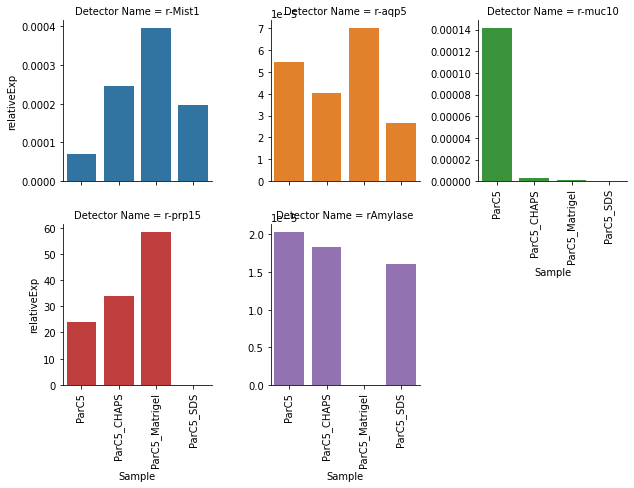

In [12]:
# Draw plots
g =  sns.FacetGrid(dff1, col="Detector Name", hue = "Detector Name", sharey=False, col_wrap=3)   # sharey for different y axis scale.                
g.map(sns.barplot, "Sample", "relativeExp")

# Rotate x axis label
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        